In [6]:

import numpy as np
import pandas as pd
import json

from DataAnalysisClass import *
from clustering_work import *
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns

single = ['aug-cc-pVDZ', 'aug-cc-pVTZ', 'aug-cc-pVQZ', 'aug-cc-pV5Z', 'aug-cc-pV6Z']
single_polarized = ['aug-cc-pCVDZ', 'aug-cc-pCVTZ', 'aug-cc-pCVQZ']
double = ['d-aug-cc-pVDZ', 'd-aug-cc-pVTZ', 'd-aug-cc-pVQZ', 'd-aug-cc-pV5Z', 'd-aug-cc-pV6Z']
double_polarized = ['d-aug-cc-pCVDZ', 'd-aug-cc-pCVTZ', 'd-aug-cc-pCVQZ']
all_basis_sets = single + single_polarized + double + double_polarized


In [7]:
csv_path = Path("csv")
csv_path.mkdir(exist_ok=True)
beta_hrs_error_path = csv_path.joinpath('beta_hrs_error.csv')
beta_para_error_path = csv_path.joinpath('beta_parallel_error.csv')
beta_hrs_path = csv_path.joinpath('beta_hrs.csv')
beta_para_path = csv_path.joinpath('beta_parallel.csv')
beta_path = csv_path.joinpath('beta_ijk.csv')


In [8]:

paper_path = Path('beta_figures')



In [9]:
#read first column as index 
beta_hrs = pd.read_csv(beta_hrs_path, index_col=0)
beta_df = pd.read_csv(beta_path, index_col=0)
# glob for .mol files in august molecules directory


In [10]:
beta_df

,Afreq,Bfreq,Cfreq,ijk,basis,molecule,Beta,a,b,c
0,0.0000,0.0000,0.0000,XXX,MRA,FNO,-5.899730,0,0,0
1,0.0000,0.0000,0.0000,XYY,MRA,FNO,-2.972730,0,0,0
2,0.0000,0.0000,0.0000,YXY,MRA,FNO,-2.972730,0,0,0
3,0.0000,0.0000,0.0000,YYX,MRA,FNO,-2.972730,0,0,0
4,0.0000,0.0000,0.0000,XYZ,MRA,FNO,-0.000220,0,0,0
...,...,...,...,...,...,...,...,...,...,...
655635,0.0974,0.0325,0.0649,YZZ,d-aug-cc-pCVQZ,LiBH4,-0.002181,6,2,4
655636,0.0974,0.0325,0.0649,ZZZ,d-aug-cc-pCVQZ,LiBH4,63.774400,6,2,4
655637,0.1136,0.0487,0.0649,XZZ,d-aug-cc-pCVQZ,LiBH4,-0.003208,7,3,4
655638,0.1136,0.0487,0.0649,YZZ,d-aug-cc-pCVQZ,LiBH4,-0.003026,7,3,4


In [11]:
# if Beta < threshold, set Beta to 0
thresh = 1e-4
beta_df['Beta'] = beta_df['Beta'].apply(lambda x: 0 if np.abs(x) < thresh else x)

In [12]:
class MRAComparedBasisDF(pd.DataFrame):
    def __init__(self, polar_data, index, values: list, PercentError: bool, *args, **kwargs):
        # Use the special_parameter to modify the DataFrame or perform additional initialization
        basis_data = polar_data.query('basis!="MRA"').copy()
        basis_data = basis_data.set_index(index)

        for value in values:
            basis_data[f'{value}MRA'] = polar_data.query('basis=="MRA"').set_index(index)[
                value]
            if PercentError:
                basis_data[f'{value}E'] = (
                            (basis_data[value] - basis_data[f'{value}MRA']) / basis_data[f'{value}MRA'] * 100)
            else:
                basis_data[f'{value}E'] = (basis_data[value] - basis_data[f'{value}MRA'])
        basis_data = basis_data.reset_index()
        # create a column of percent error in alpha
        basis_data = make_detailed_df(basis_data)
        super().__init__(basis_data, *args, **kwargs)

In [13]:
beta_basis_error_df = MRAComparedBasisDF(beta_df, index=['molecule', 'ijk', 'b', 'c', ], values=['Beta'],
                                         PercentError=True)

['D', 'T', 'Q', '5']


In [14]:
beta_hrs_error_df = pd.read_csv(beta_hrs_error_path, index_col=0)

In [15]:

def plot_basis_molecule_convergence(df, mol, vlevel):
    plot_data = df.query('molecule==@mol and b==c and valence.isin(@vlevel)').copy()
    plot_data['omega'] = plot_data['b']
    o = plot_data.omega.unique()
    mra = plot_data.beta_MRA.unique()
    mra_data = pd.DataFrame({'omega': o, 'beta_MRA': mra})

    pal = 'magma'

    plot_data.valence = plot_data.valence.astype('category')
    plot_data.valence = plot_data.valence.cat.remove_unused_categories()
    num_valence_levels = len(plot_data.valence.unique())
    vlevel = vlevel[:num_valence_levels]

    plot_data.valence = plot_data.valence.cat.reorder_categories(vlevel, ordered=True)

    plot_data.omega = plot_data.omega.astype('category')
    plot_data.omega = plot_data.omega.cat.remove_unused_categories()

    type_order = ['aug-cc-pVnZ', 'aug-cc-pCVnZ', 'd-aug-cc-pVnZ', 'd-aug-cc-pCVnZ']
    # create an omega column 
    g = sns.FacetGrid(data=plot_data, col='Type', col_order=type_order, sharey=True, sharex=False, height=6, aspect=.5,
                      despine=False)
    g.map_dataframe(sns.lineplot, x='valence', y='Beta', hue='omega', alpha=.5, palette=pal, lw=1,
                    legend=True)
    g.map_dataframe(sns.scatterplot, x='valence', y='Beta', hue='omega', alpha=.95, palette=pal, s=100)

    mra_colors = sns.color_palette(pal, n_colors=len(o))
    for ax in g.axes.flat:
        for i, beta in enumerate(mra_data.beta_MRA):
            ax.axhline(beta, color=mra_colors[i], linestyle='--', label='MRA', alpha=.7)
        ax.patch.set_alpha(0.3)

    g.add_legend(title='Frequency', loc='center left', bbox_to_anchor=(1, 0.5))

    g.figure.tight_layout()
    return g


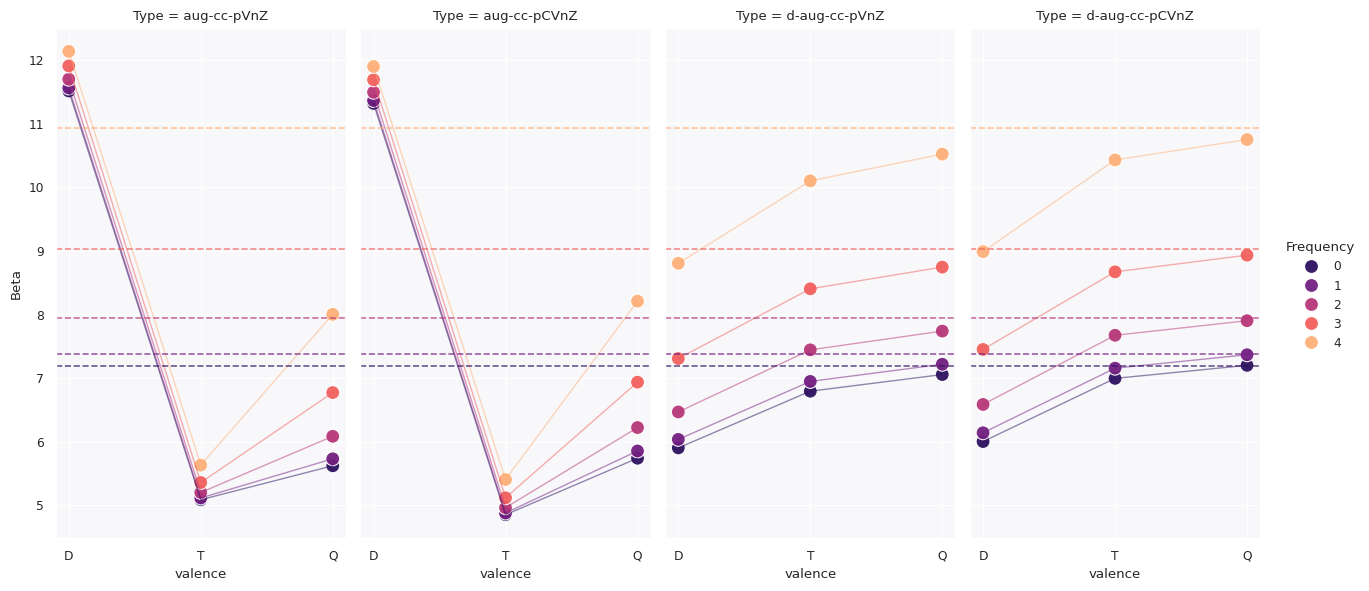

In [16]:
# These values are plotted at values where beta == c therefore the outgoing frequency is 2*omega
plot_basis_molecule_convergence(beta_hrs_error_df, 'CH3Cl', ['D', 'T', 'Q', '5'])

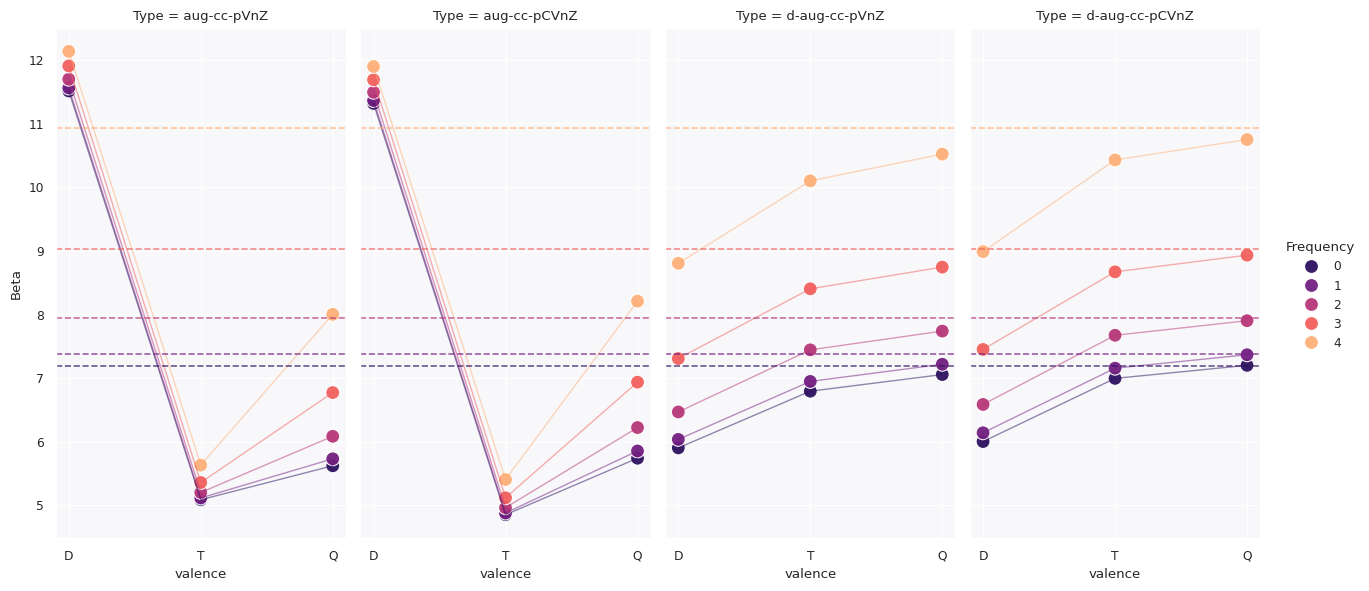

In [17]:
beta_hrs_error_df.query('molecule=="HCl"').query('b==c')
plot_basis_molecule_convergence(beta_hrs_error_df, 'CH3Cl', ['D', 'T', 'Q', '5'])


In [20]:

def read_mra_beta(json_file, mol_name):
    json = pd.read_json(json_file)
    beta_df = pd.DataFrame.from_dict(json)
    # rename A-freq B-freq C-freq to Afreq Bfreq Cfreq
    beta_df.rename(columns={'A-freq': 'Afreq', 'B-freq': 'Bfreq', 'C-freq': 'Cfreq'}, inplace=True)
    # round Afreq Bfreq Cfreq to 3 decimal places
    beta_df.Afreq = beta_df.Afreq.round(3)
    beta_df.Bfreq = beta_df.Bfreq.round(3)
    beta_df.Cfreq = beta_df.Cfreq.round(3)
    # combine A-freq B-freq C-freq to ijk
    beta_df['ijk'] = beta_df['A'].astype(str) + beta_df['B'].astype(str) + beta_df['C'].astype(str)
    beta_df = beta_df.drop(columns=['A', 'B', 'C'])
    # set basis name to MRA
    beta_df['basis'] = 'MRA'
    beta_df['molecule'] = mol_name

    #beta_df = beta_df.set_index('molecule')
    #beta_df = beta_df.reset_index()
    return beta_df


hf_beta_df = read_mra_beta(hf_beta_path, 'H2O')
hf_beta_df.Afreq.unique()

In [24]:
def query_basis_data(df,omega_b,omega_c):
    om=df.Bfreq.unique()

    b = om[omega_b]
    c = om[omega_c]

    return df.query('Bfreq==@b and Cfreq==@c')


In [25]:

def reconstruct_full_beta_ijk(freq_data):
    ex = freq_data.copy()
    ex['equal_ijk'] = freq_data['Beta'].apply(lambda x: str(x) if not isinstance(x, float) else str(None))
    ex['equal_ijk'] = ex['equal_ijk'].apply(lambda x: (''.join(x[5:-1].split(','))) if str(None) else str(None))
    ex.set_index('ijk', inplace=True)
    for index, row in ex.iterrows():
        if row.equal_ijk != str():
            ex.at[index, 'Beta'] = ex.at[row.equal_ijk, 'Beta']
    ex.reset_index(inplace=True)
    ex.drop(columns='equal_ijk', inplace=True)
    return ex


def read_basis_quad(json_file):
    with open(json_file) as json_file:
        json_file = json_file.read()
        json_file = json.loads(json_file)
    basis_data = pd.DataFrame.from_dict(json_file['Quad'])
    basis_data.rename(columns={'A-freq': 'Afreq', 'B-freq': 'Bfreq', 'C-freq': 'Cfreq'}, inplace=True)
    # round Afreq Bfreq Cfreq to 3 decimal places
    basis_data.Afreq = basis_data.Afreq.round(3)
    basis_data.Bfreq = basis_data.Bfreq.round(3)
    basis_data.Cfreq = basis_data.Cfreq.round(3)
    # combine A-freq B-freq C-freq to ijk
    basis_data['ijk'] = basis_data['A'].astype(str) + basis_data['B'].astype(str) + basis_data['C'].astype(str)
    basis_data = basis_data.drop(columns=['A', 'B', 'C'])
    # rename Beta Value to Beta 
    basis_data.rename(columns={'Beta Value': 'Beta'}, inplace=True)
    bfreqs = basis_data.Bfreq.unique()
    cfreqs = basis_data.Cfreq.unique()

    ex = basis_data.copy()
    ex['equal_ijk'] = ex['Beta'].apply(lambda x: str(x) if not isinstance(x, float) else str(None))
    ex['equal_ijk'] = ex['equal_ijk'].apply(lambda x: (''.join(x[5:-1].split(','))) if str(None) else str(None))
    ex.set_index(['ijk','Bfreq','Cfreq'], inplace=True)
    ex.sort_index(inplace=True)
    ex=ex[~ex.index.duplicated(keep='first')]
    for index, row in ex.iterrows():
        if row.equal_ijk != str():
            # create new index = to equal_ijk,Cfreq,Bfreq
            new_index= (row.equal_ijk, index[2], index[1])
            ex.loc[index,'Beta'] = ex.loc[new_index,'Beta']
    ex.reset_index(inplace=True)
    ex.drop(columns='equal_ijk', inplace=True)
    return ex
    


In [51]:

mol = "LIH"
f1=0
f2=0

basis_path = Path(
    "/home/ahurta92/data/beta_paper_database/dalton/hf/{}/dipole/quad_{}-d-aug-cc-pCVQZ.json".format(mol, mol))
basis_data = read_basis_quad(basis_path)
basis=query_basis_data(basis_data,f1,f2).sort_values('Beta').query('Beta.abs()>1e-2').set_index('ijk').Beta
mra_path = Path("/home/ahurta92/data/may2024/output/{}/output/beta.json".format(mol))
mra_data = read_mra_beta(mra_path, mol)
mra=query_basis_data(mra_data, f1, f2).sort_values('Beta').query('Beta.abs()>1e-2').set_index('ijk').Beta
pd.concat([basis,mra],axis=1,keys=['basis','mra'])

FileNotFoundError: [Errno 2] No such file or directory: '/home/ahurta92/data/beta_paper_database/dalton/hf/LIH/dipole/quad_LIH-d-aug-cc-pCVQZ.json'

In [82]:
mol='LiH'
basis_path = Path(
    "/home/ahurta92/data/beta_paper_database/dalton/hf/{}/dipole/quad_{}-d-aug-cc-pCVQZ.json".format(mol, mol))
basis_data = read_basis_quad(basis_path)
basis=query_basis_data(basis_data,f1,f2).sort_values('Beta').query('Beta.abs()>1e-2').set_index('ijk').Beta
basis

ijk
XZY       0.02758
YXZ       0.02758
XYZ       0.02758
YZX       0.02758
ZXY       0.02758
ZYX       0.02758
YYZ    187.367177
YZY    187.367177
ZYY    187.367177
ZXX    187.368614
XZX    187.368614
XXZ    187.368614
ZZZ    306.980888
Name: Beta, dtype: object

In [83]:
data_base=Path("/home/ahurta92/data/summer_2024/may2024")
mol_list_path = data_base.joinpath("mols_list")
# read mol_list

with open(mol_list_path) as mol_list:
    mol_list = mol_list.read().splitlines()


In [84]:
len(mol_list)

72

In [85]:
# split into N lists

def split_list(lst, n):
    k, m = divmod(len(lst), n)
    return (lst[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))


mol_list = list(split_list(mol_list, 10))




In [89]:
' '.join(mol_list[2])

'NaCN OCl2 CH3Cl SCl2 HCCF LiH BF'

In [87]:
class mra_data:
    def __init__(self,mol,data_base):
        self.mol = mol
        self.data_dir = data_base.joinpath(mol)
        calc_path = self.data_dir.joinpath("calc_path.json")
        self.calc_path_json = json.load(open(calc_path))
        self.alpha_json=pd.DataFrame(json.load(open(self.data_dir.joinpath(self.calc_path_json['alpha_json_path']))))
        self.beta_json=pd.DataFrame(json.load(open(self.data_dir.joinpath(self.calc_path_json['quadratic_json_path']))))

In [75]:
data_base=Path("/home/ahurta92/data/may2024/output")
h2o=mra_data('He',data_base)

In [67]:
h2o.alpha_json

,omega,ij,alpha
0,0.00000,XX,1.322332e+00
1,0.00000,XY,-6.702972e-15
2,0.00000,XZ,1.594558e-14
3,0.00000,YX,-5.967449e-15
4,0.00000,YY,1.322316e+00
...,...,...,...
76,0.39534,YY,1.592822e+00
77,0.39534,YZ,-5.613565e-15
78,0.39534,ZX,1.962319e-14
79,0.39534,ZY,1.474515e-15


In [81]:
h2o.beta_json.query('B-freq==0.0 and C-freq==0.0')

UndefinedVariableError: name 'freq' is not defined

In [80]:
h2o.beta_json

,A-freq,B-freq,C-freq,A,B,C,Beta
0,-0.00000,0.00000,0.00000,X,X,X,7.439776e-02
1,-0.00000,0.00000,0.00000,X,Y,Y,1.081072e-05
2,-0.00000,0.00000,0.00000,Y,X,Y,1.081072e-05
3,-0.00000,0.00000,0.00000,Y,Y,X,1.081072e-05
4,-0.00000,0.00000,0.00000,X,Z,Z,1.081065e-05
...,...,...,...,...,...,...,...
400,-0.39534,0.19767,0.19767,Z,Z,X,5.525105e-02
401,-0.39534,0.19767,0.19767,Z,Y,Y,1.513895e-07
402,-0.39534,0.19767,0.19767,Z,Y,Z,-4.935009e-02
403,-0.39534,0.19767,0.19767,Z,Z,Y,-4.935009e-02
